# Analysis of Ad-Hoc Communications Network

__Problem Statement__: <br> You have been asked to help with planning an ad-hoc communications network over a large rectangular region. Each individual tower can monitor a rectangular subsection of a specific width and height. The main problem is that none of the individual towers can provide coverage for the entire region of interest. Communications towers are unreliable and are put up independently and at random. You have no control over where or how big a tower’s footprint is placed. Importantly, due to technical issues such as cross-talk, no individual rectangular subsection can have multiple towers providing coverage for it. That is, there can be no overlap between any pair of rectangular subsections provided by the two respective towers. In any case, the desire is to maximize the coverage area of any available communications tower.

__Constraints__:

- No rectangule's footprint should be outside the area specified
- Positions of rectangeles are randomly sampled
- Coordinates of the rectangular areas are integer based
- No overlap among the coverages of the towers
- If there is a overlap then the new footprint must be trimmed, it should be trimmed in such a way that the final foot print is a sub rectangle and must have the maximum possible area as long as it does not have any overlap
- If no such tower is possible then try generate a new tower in place of this (in case the total coverage is completely full then we can stop)

I assume that the user gives me 3 inputs:
1. l: The dimension of the region in the x direction.
2. w: The dimension of the region in the y direction.
3. n: The number of desired towers to be set up.
<br>
__NOTE__:The __convention followed__ in the entire code is as follows:
- __origin is the top left corner of the plot__
- the axes are as follows: 
![Example](plotex.png)
- __length__ of the rectangle as represented by l_rect corresponds to the size of the rectangle along x axis
- __width__ of the rectangle as represented by w_rect corresponds to the size of the rectangle along y axis
- i.e length is not necessary the longest dimension it is the dimension alongx axis (Note this does not hinder anything as per the problem it is just a convention adopted to make it easy to read the code)
- For the plot above length is 1 width is 2
- __(i,j)__: i is the row index, j is the column index, for the plot above (5,9) is the top left corner

In [2]:
#Assuming the following inputs:
# total rectangular area coordinates


# Importing the required libraries etc
import random # This is needed for various tasks like randomly selecting the rectangles, colors
import numpy as np # Numpy arrays and its various functions is used to efficiently remember total coverage the filled area, check if a new tower has overlap etc
import matplotlib.pyplot as plt # Basic library used for making the visualizations
import matplotlib.patches as patches # Patches are used to store and plot multiple rectangles in a given figure
from copy import copy # This is required for add_patch() in matplotlib to work as we reuire for this task
%matplotlib inline 
# This is required as othrwise the plots cannot be seen within the jupyter notebook
from IPython.display import Image # for displaying local images in the jupyter notebook


I use classes to make it more readable and for the ease of re-implementation/debugging. We have main parts to to the solution:
 1. Storing the Information of the grid in an appropriate datastructure
 2. Sampling position and dimensions for a tower
 3. Checking for overlaps
 4. Finding the best sub rectangle if one exists
 5. Plotting

I address these in the following way


#### Storing the Information of the grid in an appropriate datastructure

#### Choosing the data srtucture:
- We need to store the entire information of the coverage etc in a data structure in python
- We will repeatedly be accessing it to check for overlaps etc so accessing the data must be fast. 
- We will also be making changes to the values stored in the grid quite often so the datastructure must enable us to modify the data quikcly. 
- Also in regard to th data stored (as explained below it will be 1's and 0's) all of the locations need to store data of the same datatype (int).
- As far as the size is considered the size of the grid is constant so the object used can be of a static size.

Due to all the reasons explained above Numpy arrays seem to be the best possible choice for the task as they have fast access to data, data can be modified fast, uniform data type, constat space, also as these are pre-compiled and very close to native c arrays they are extremely fast. So due to the entioned points I choose them over other possible choices like native python lists which would also work but would be much slower than my current choice of using numpy arrays.


#### Storing the information in the NumPy arrays:
I have two NumPyarrays which store the information about the grid:
1. grid:
        
        Given a w x l area, we will have (w+1) x (l+1) integer base coordinate points,grid is a numpy array of size (width+1)x(length+1) whose each (i,j)th entry corresponds to a integer (i,j) coordinate point in the area to be covered. If a vertex is within the covered area the corresponding value is 1 otherwise 0.This is used to keep track of which of the points lie inside the covered area, initially all are initialized to zero.
        Ex: The grid is initially for w=3,l=3 
        [
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
        ]
        now let us say we insert a rectangle whose topleft corner is at (0,0) and has length 2 and width 3,
        grid will be updated to
        [
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0]
        ]
        In this way after each insertion we can keep updating the data and keep tracking about which of the vertices in the grid are covered. This is very useful for debugging/intuitively seeing how the algorithm works.
        
2. overlap_grid :
        
        
        This is the important one of the two. The above one doesnot help much checking for overlap but this one does and in fact it providees an easy way to check for overlaps.Given an area of wxl, as pointed above that will have (w+1)x(l+1) integer based coordinates, now if we think carefully this will give us wxl unit squares in the grid. If we can somehow mark each of these unit squares as covered or not then we can quite easily check for overlaps etc and that is what ovrlap grid does, it is of size wxl and each element represents the coverage of network in the corresponding unit square in the given area. If there is network coverage the position corresponding to that unit square is 1 otherwise it is 0. So It is a numpy array of size width x length.    
        Ex: If the grid (i.e the first array mentioned above) is 
        [
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0]
        ]
        we can assume grid is made up of wxl square of unit area, now we can efficiently keep track
        of the coverage area in terms of these square by book keeping them in an w x l array which is the 
        overlap_grid. For the above case overlap_grid will be
        [
        [1,1,0],
        [1,1,0],
        [1,1,0],
        ]
So this is how the data regarding the coverage is stord in the code.  

### Accessing and modifying each value is O(1), so for each new tower it is O(w.l)
### Space complexity is also O(w.l) for this part

#### Sampling position and dimensions for a tower

Once we are done with deciding how to store the data the next task is determininng how to sample the the location and the dimensions of a rectangle:

1. For this I assume that the position of the recangle is determined by sampling its top left corner. Other methods I tried were considering bottom right corner, which I disregarded as it was esier for me to visualize the rectangles using the top left corner rather than the bottom right corner(perhaps because I am right handed!), I disregarded the center as that posed extra difficulties/constraints for the next step i.e determining length and breadth (for example they only had to be even and could not be odd if  chose integer based center etc and it would simply make things complicated). So I choose the top left corner representation. 

2. I randomly(uniform) pick integers in the range [0,w-1] to pick i and [0,l-1]  to pick j and get (i,j) as my top left corner.

3. Now I need to pick the length and width of the rectangle, I call as length the dimension i x directioon adn as width the dimension in y-direction, so for l_rect i pick random integers in range [1,l] and for w from range [1,w] if both of them satisfy tha conditions such that the footprint lies inside the area if the rectangle is placed at (i,j) sampled above then  (i,j,l_rect,w_rect) makes up out candidate rectabgle description. if they do not lie inside the region then l)rect,w_rect are resampled untill we get values that satisfy the required condition to lie inside.

4. This approach of resampling was chosen rather than constraining the distribution at each stage as it is much easier and serves the purpose well.


Ex: For l=10, w= 8,    (i,j)=(5,9) , l_rect=1 and w_rect=2 represents the following rectangle:
![Example](plotex.png)

#### Checking for overlaps

As NumPy has a really convenient and efficient slicing system I wanted to make use of it for checking for overlaps in a fast efficeient and simple way, so if (i1,j1) is the top left corner of the rectangular footprint of a tower and if(i2,j2) is the bottom right corner of the rectangular footprint of a tower, then all we need to check if it overlaps or not is just to check the array overlap_grid we have particularly overlap_grid[i1:i2,j1:j2] and check if there is atleast one 1 in this slice which would indicate an overlap(this is done using np.any()). thus we have an easy way to check for overlaps.

For example in the following case:

![Example](overlap1.png)
![Example](overlap2.png)



### This is O(w.l)

#### Finding the best sub rectangle if one exists
Once we check if there is overlap or not we need to check find a way to trim. For this I follow the brute force method as follows:
If the rectangle which has overlap is as follows:


Then we consider all the possible sub rectangles inside this rectangle and check if they are valid or not i.e if they have zero overlap or not, then if we have such valid rectangles we select the one which has maximum area among these and then choose it.

To explain better if the above rectangle is denoted by (1,2),l_rect=3,w_rect=2
Then to consider all the possible sub rectangles we start off with choosing all the sub rectangles with top left corner as (1,2) and go over all of them by choosing the bottom right corner iteratively as shown below in first 3 cases:
![Example](dd.png)

and the top left corner aso should be given all the possible corners, i.e it could be (3,4) as shown above in row 4 column 2 and so on.


So once we decide to follow this approach we just need to check for every sub rectangle if it has overlap or not and then choose the one with max area. If this is not possible i.e if the tower's footprint lies entirely inside the previous coverage then we return -1 to indicate that we could not place this tower, this ensures we that the program then goes and sample another tower candidate and without increasing the tower count(as we desire to have n towers). Sometime thi is difficult as what could happen is if one of the corners is not filled then they get filled only for a few particular kind of rectangles for ex if the top left corner in the grid is empty and all other area is filled then unless both values of the randomly smapleed top left cotner coordinate are 0 we will not get improvement, this needs 1/w x 1/l probability so it can be low and thus the algorithm may run for a while. Also it is possiblr that the first few toers i.e < n might completely fill the area so fo such a case I keep monitoring the area filled and in case the entire area is filled the program stops even ifnumber of towers is less than n.
### This is O(w.l^4^)

Example in a simulation:
![Example](overlap1.png)
![Example](overlap2.png)
We realize there is an overlap and then trim it accordingly
![Example](overlap3.png)

#### Plotting:

I use the matplotlib library for plotting the rectangles in the grid, I choose the colour of each rectangle randomly, I plot the grid after each new tower is proposed and after trimming if need be so that the user can clearly see how the algorithm works. 

## An example run can be seen below

In [24]:
class tower:
    """
    'tower' is the class which encapsulates all the variables/attributes and the helper functions that
    are needed. Once and object of class 'tower' is instantiated with the required length and breadth 
    of the area and number of towers toset up, calling .run() will run the entire simulation.
    
    Attributes:
    w: length of the area along y axis
    l: length of the area along x axis
    n: number of towers
    overlap_grid:grid to keep track of area covered
    grid:grid to keep track of vertices covered
    
    
    Methods:
        run: call this to start the simulation
     """
            
    
    def __init__(self,l=5,w=3,n=10,plot=True):
        #plot is just to specify if we want plots or not
        assert isinstance(l,int)
        assert isinstance(w,int)
        assert isinstance(n,int)
        self.w=w                       # dimension along y axis 
        self.l=l                       # dimension along x axis
        self.n=n                       # number of towers to be inserted
        self.flag=True                 # flag to make sure only one simulation is run for instance
        self.overlap_grid=self.prepare_overlap_grid() # prepares a grid to keep track of occupied area,
                                                   # used for checking overlaps
        self.grid=self.prepare_grid()  # prepares the grid to keep track of the occupied vertices, 
                                       # mostly useful for debugging  
        self.rectangles=[]             # list to store the rectangular patches for visualization
        self.colors=["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.n)]
                                       #list of n randomly chosen colors (hex codes)
        self.plot=plot
    def run(self):
        """
        runs the simulation.
        once we create an instance of the class tower
        calling t.run() will run the entire simulation along with visualization.
        Can only be run once for another simulation we need to instantiate again.
        """
        
        i=0
        while i < self.n and self.stats()<1  and self.flag:# run n times for each of the n towers or untill fully covered
            ci,cj=self.generate_topleft()                   #generate a top left corner
            l_rect,w_rect=self.generate_rectangle(ci,cj)    #generate length and width
            retval=self.insert_rectangle(ci,cj,l_rect,w_rect,i) #try and insert the tower 
            
            if retval!=-1:                                  # if tower is inserted successfully
                i+=1 
            else:
                if self.plot:
                    self.plot_grid()                            # if the tower could not be inserted plot the 
                                                            # visualization s that the user can visually see it
                                                            
        if not self.flag:                                   # if someone calls the run function twice
            print('You can only run once, create a new instance again')
        self.flag=False                                     # set flag to False after one run
        return
    
    def prepare_grid(self):
        """
        Prepares the grid which is a numpy array of size (width+1)x(length+1) each (i,j)th entry corresponds
        to a integer (i,j) coordinate point in the area to be covered. This is used to keep track of which of
        the points lie inside the covered area, initially all are initialized to zero.
        Ex: If the grid is initially 
        [
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
        ]
        now let us say we insert a rectangle whose topleft corner is at (0,0) and has length 2 and width 3,
        grid will be updated to
        [
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0]
        ]
        This is useful for debugging.
        """
        #called initialy to setup a numpy array of zeros
        return np.zeros((self.w+1,self.l+1))
    
    def prepare_overlap_grid(self):
        """
        Prepares the overlap_grid that is used while checking if there is an overlap or not
        it is a numpy array of size width x length, if width=w and length = l as specified by the user
        then we will clearly have (w+1) x (l+1) integer pairs (i,j) in the grid which are represented in
        grid. 
        Ex: If the grid is
        [
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0],
        [1,1,1,0]
        ]
        we can assume grid is made up of wxl square of unit area, now we can efficiently keep track
        of the coverage area in terms of these square by book keeping them in an w x l array which is the 
        overlap_grid. For the above case overlap_grid will be
        [
        [1,1,0],
        [1,1,0],
        [1,1,0],
        ]
        """
       #called initialy to setup the numpy array of zeros
        return np.zeros((self.w,self.l))
    
    
    
    def generate_topleft(self):
        """
        Randomly generates a candidate for the top left corner of a tower's footprint
        
        Returns:
            tuple(int,int) 
            (ci,cj): top left corner for the next tower
        """
                                                #called to generate topleft corner 
        ci=np.random.randint(0,self.w)          #using random.randint() ensures that we sample integer points
        cj=np.random.randint(0,self.l)
        return ci,cj
    def generate_rectangle(self,ci,cj):
        """
        Randomly generates a tuple for length,width for the new tower with (ci,cj) as its top left corner
        (takes care that the length, width are valid)
        Args:
            ci,cj:
            (ci,cj): top left corner for the tower
        Returns:
            tuple(int,int) 
            (l_rect,w_rect): length,width of the tower
        """
                                                       # called to generate height and width
        c=1
        while c==1:
            w_rect=np.random.randint(1,self.w)
            l_rect=np.random.randint(1,self.l)
            if ci+w_rect<=self.w and cj+l_rect<=self.l:# ensuring that the tower's footrint is within the area
                c=0                           
        return l_rect,w_rect
    
    def trim(self,ci,cj,l_rect,w_rect):
        """
        Trims the new rectangle and finds the maximum area subrectangle that has no overlap with
        the existing coverage
        
        Args:
        ci:
        cj:(ci,cj) is the top left corner
        l_rect:length of the rectangle
        w_rect:width of the rectangle
        
        Returns:
        if it is possible to find a subrectangle with zero overlap the returns:
        list [i,j,k,l]: (i,j) is the top left corner and (k,l) is the bottom right corner of the trimmed 
        rectangle
        else return:
        scalar: -1  
        """
        #there is overlap so check all possible sub rectangles and
        #choose the one with maximum area among the valid ones
        
        max_area=0
        
        for i in range(ci,ci+w_rect):
            for j in range(cj,cj+l_rect):#(i,j) is the top left corner of the sub rectangle
                for k in range(i+1,ci+w_rect+1):
                    for l in range(j+1,cj+l_rect+1):      #(k,l) is the bottom right corner of the sub rectangle
                        if not self.check_overlap(i,j,k,l): # checking if sub rectangle has overlap or not
        
                            candidate_area=(k-i)*(l-j)      
                            if candidate_area>max_area:   # checking if the valid subrectangles area is  
                                                          # greater than previous max
                                max_area = candidate_area   
                                rect=[i,j,k,l]
        if max_area==0:                                   # checking if it was not possible to insert
            return -1
        else:
            return rect
                            
            
    
    def check_overlap(self,i1,j1,i2,j2):
        """
        Args:
            i1(int):
            j1(int):
                    (i1,j1) is the top left corner of the rectangular footprint of a tower
            i2(int):
            j2(int):
                    (i2,j2) is the bottom right corner of the rectangular footprint of a tower
        Returns:
            bool: True if the rectangle has overlap False if it has no overlap
        """
        #to check if there is a overlap
        
        return np.any(self.overlap_grid[i1:i2,j1:j2]) # checking if any of the unit squares inside the 
                                                      # rectangle are occupied

                                      
    def update_values(self,i1,j1,i2,j2):
        """
       
        Updates(book keeping) the value of the overlap_grid and grid(inplace) so as to reflect the updated 
        occupied area/covered area
        Args:
            i1(int):
            j1(int):
                    (i1,j1) is the top left corner of the rectangular footprint of the new tower(after it is 
                    trimmed appropriately as required in case that is needed) that is being setup
            i2(int):
            j2(int):
                    (i2,j2) is the bottom right corner of the rectangular footprint of the new tower(after 
                    it is trimmed appropriately as required in case that is needed) that is being setup
        Returns:
            (does everything in place)
        """
        #to update the values in the grid after selecting the trimmed rectangle
        self.overlap_grid[i1:i2,j1:j2]=1  # filling the covered vertices by 1
        self.grid[i1:i2+1,j1:j2+1]=1      # filling the covered unit squares by 1
        return 
                
    def insert_rectangle(self,ci,cj,l_rect,w_rect,num):
        """
        Inserts/tris to insert the new rectangle according to the rules given and plots the visualization
        
        Args:
        ci:
        cj:(ci,cj) is the top left corner
        l_rect:length of the rectangle
        w_rect:width of the rectangle
        num: the number of the rectangle being inserted
        
        Returns:
        scalar 1: if it is possible to insert the rectangle(with or without trimming)
        scalar -1: if it is impossible to insert the new rectangle without having any overlap
        """
        if self.check_overlap(ci,cj,ci+w_rect,cj+l_rect):     # check for overlap
            self.rectangles.append(patches.Rectangle(         # append the untrimmed rectangle 
            (cj,ci), l_rect,w_rect,
            color=self.colors[num],))
            if self.plot:
                self.plot_grid()                                  #visualize the untrimmed rectangle
            self.rectangles=self.rectangles[:-1]
            trimmed_rect=self.trim(ci,cj,l_rect,w_rect)       #try to trim
            if trimmed_rect==-1:
                return -1                                     #indicate if unable to find a trim 
            
            
            self.rectangles.append(patches.Rectangle(         #append the trimmed
            (trimmed_rect[1],trimmed_rect[0]), trimmed_rect[3]-trimmed_rect[1],trimmed_rect[2]-trimmed_rect[0],
            color=self.colors[num],))
            self.update_values(trimmed_rect[0],trimmed_rect[1],trimmed_rect[2],trimmed_rect[3])
                                                              #update both grids
           

            if self.plot:
                self.plot_grid()                                   #visualize                            
            return 1
        else:
                                                              #if no need of to trim
            self.rectangles.append(patches.Rectangle(         #append the rectangle
            (cj,ci), l_rect,w_rect,
            color=self.colors[num],))
            self.update_values(ci,cj,ci+w_rect,cj+l_rect)     #update both grids
            
            if self.plot:
                self.plot_grid()                                  #visualize
            return 1
                                      
    def stats(self):
        """
        Calculates the proportion of area covered
        
        Returns:
            float: proportion of area covered
        """
        return np.sum(self.overlap_grid)*1.0/(self.w*self.l)
    def plot_grid(self):
        """
        Plots all the rectangular footprints for the towers etup untill the current time
        """
        #references for plotting function:
        # http://matthiaseisen.com/pp/patterns/p0203/ (this function is taken from this link and modified as needed)
        #https://stackoverflow.com/questions/47554753/can-not-put-single-artist-in-more-than-one-figure
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        ax.set_ylim(ax.get_ylim()[::-1])
                                                    # invert the axis
        ax.xaxis.set_ticks(np.arange(0, self.l+1, 1))
        ax.xaxis.tick_top()                         # and move the X-Axis      
        ax.yaxis.set_ticks(np.arange(0, self.w+1, 1)) # set y-ticks
        ax.yaxis.tick_left()                        # remove right y-Ticks
        
        ax.xaxis.set_label_position('top') 
        plt.xlabel('--- x -->', fontdict=None, labelpad=None)
        plt.ylabel('<-- y ---', fontdict=None, labelpad=None)
        for p in self.rectangles:                   #plotting the rectangles
            ax.add_patch(copy(p))
         
        
        

/home/sai/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


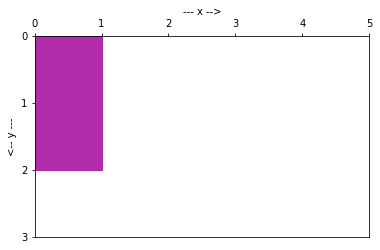

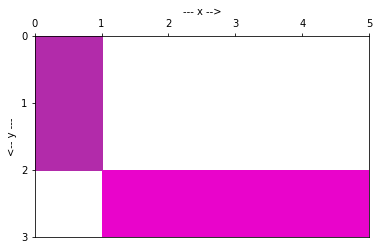

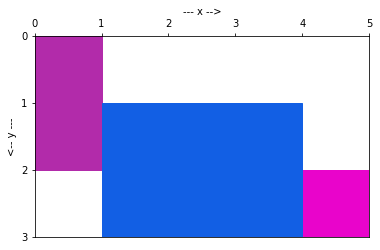

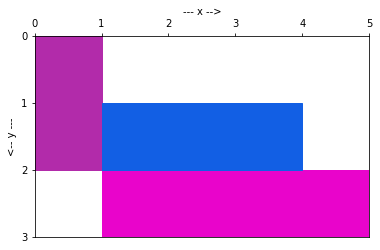

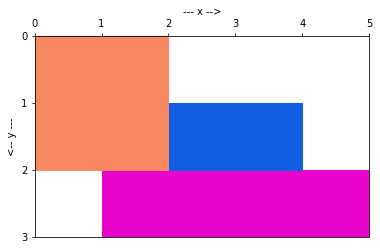

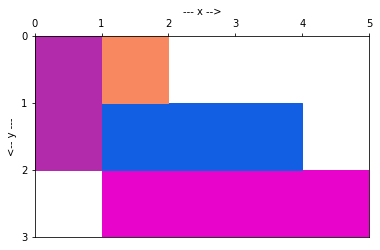

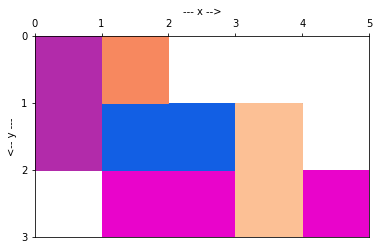

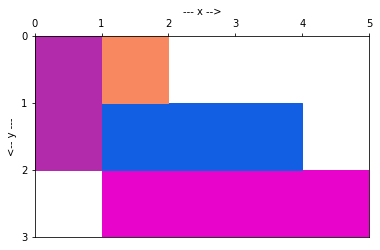

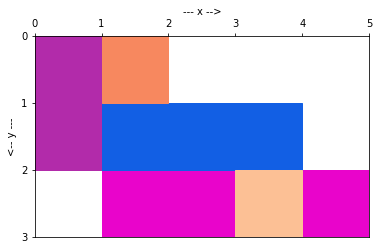

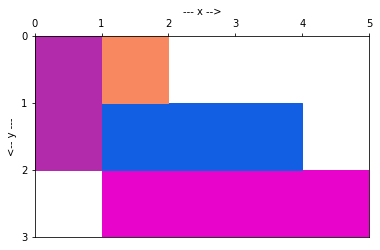

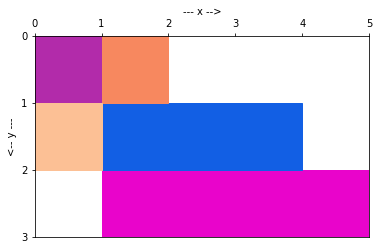

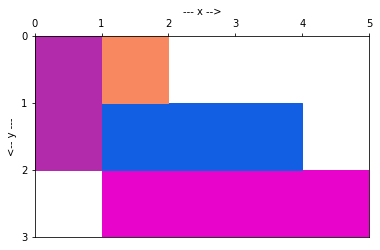

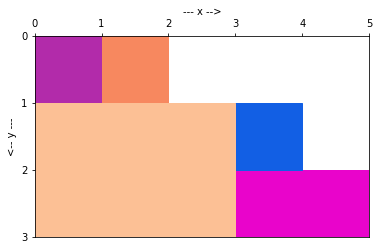

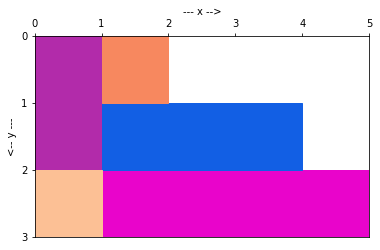

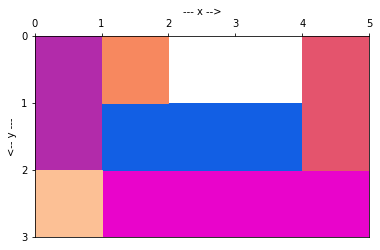

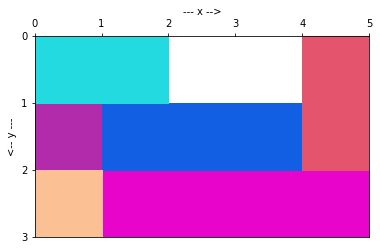

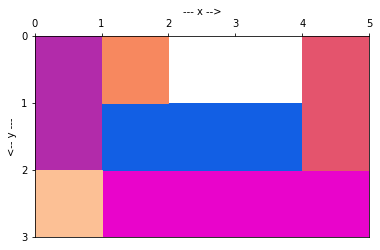

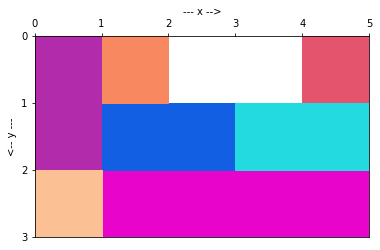

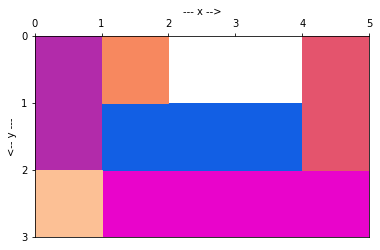

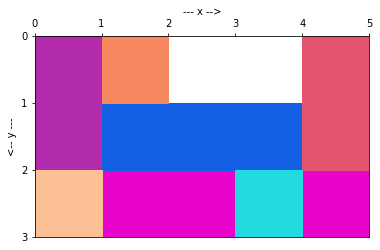

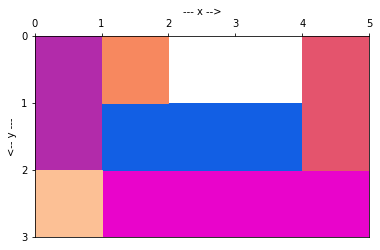

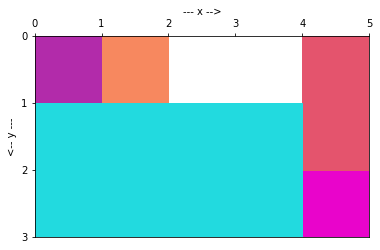

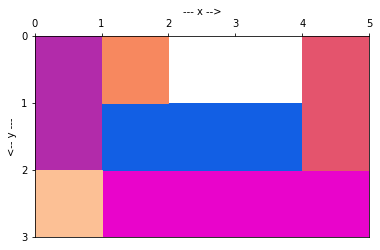

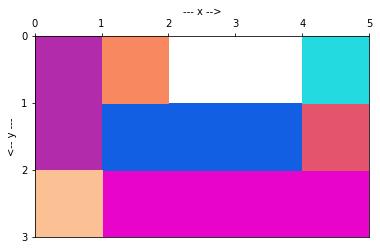

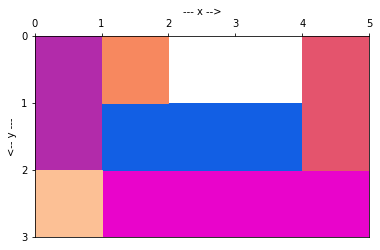

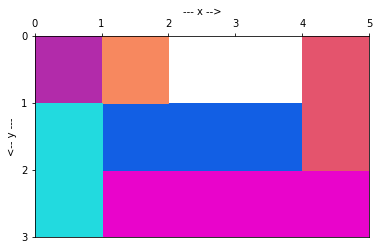

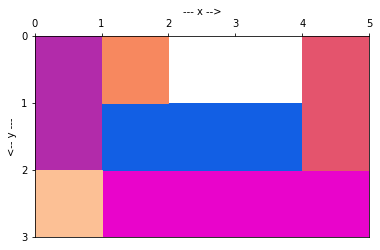

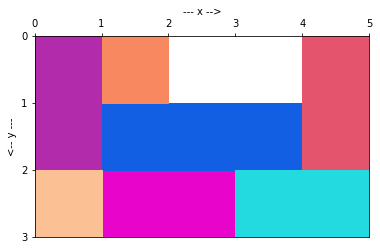

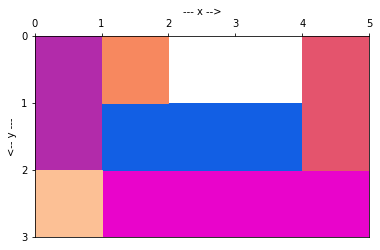

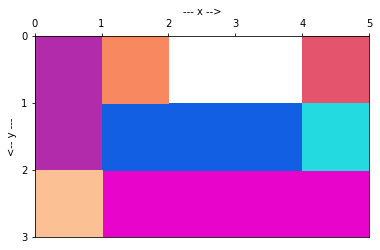

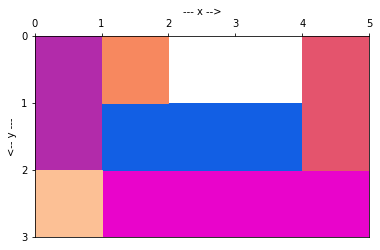

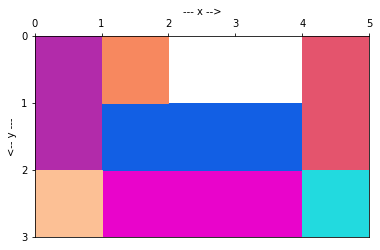

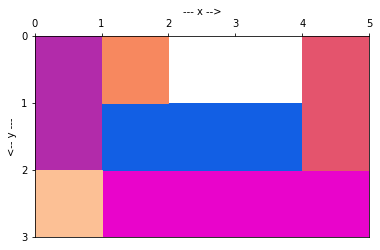

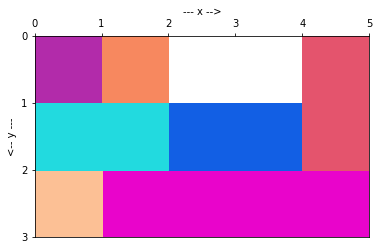

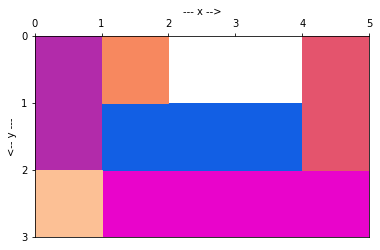

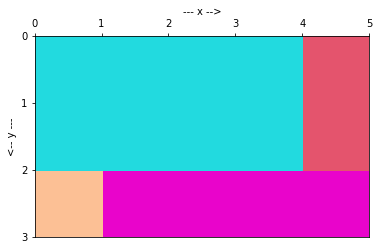

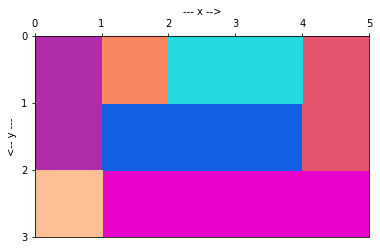

In [12]:
from __future__ import print_function

t=tower(l=5,w=3,n=10)
t.run()

In [16]:
print('proportion of area occupied = ',t.stats())

proportion of area occupied =  1.0


In [18]:
p=tower()

In [19]:
p.stats()

0.0

### Number of required towers for full coverage for a given (w,l)

For this task I use the law of large numbers, i.e I repeat the experiment multiple times for a given w,l pair and each time I start with n=1 and keep increaing it till I see the smallest value of n for which we get full coverage and store that value, I do this multiple times and then find the average of these which will be agood estimate for the actual average number of towers required. We can see the code below.

In [32]:
def find_average_n(w,l):
    import math
    lis=[]
    for i in range(1000):#running the experiment 1000 times
        num=1
        while(1):
            p=tower(w=w,l=l,n=num,plot=False)
            p.run()
            if p.stats()==1.0:
                lis.append(num)
                break
            num+=1
    return math.ceil(sum(lis)*1.0/len(lis))

In [33]:
find_average_n(5,3)

9

In [34]:
find_average_n(3,5)

9

In [35]:
find_average_n(3,5)

9

_We can see that both w=5,l=3  and w=3 and l=5 have similar values and that is what we would expect due to the symmetry_ 

In [36]:
find_average_n(10,5)

16

###  Analysis and trade offs

- __Space Complexity__ :

        For space complexity we have the two numpy arrays storing the information about the region, the first one is grid (w+1)x(l+1) and the second one is overlap_grid(wxl) although the array grid is not used in run() and costs a lot of memory it is very useful for debugging and printing out the checking so I chose to stick with it any ways it does not change the space complexity, in addition to these we have two lists for storing n rectangles and n colors, so al together the space comlexity is O(wxl)
 
- __Time Complexity__ :

        For time complexity I am reporting the individual functions's time complexities because in a few cases like the sapmling function for length and breadth we will have random time, we would have to take the expectation of the time complexity so i did not do it. The check_overlap() will take O(wxl) (as in worst case it has to check all the overlap_grid()), update_values() also similarly will take O(wxl), trim() will take O(w^2^ x l^2^) as we list out all possible sub rectangles. (As n rectangles are inserted I would expect the overall complexity to behave similar to O(nx w^2^ x l^2^)).
        
- __Trade offs__ :
          
- We are using a brute force method to find the optimal sub rectangle, hence we have a high time complexity but on the other hand this offers a straigh forward and intuitive solution to the problem at hand and importantly as n,w,l will not be too huge it is all right to use this approach for practical cases.
        
- While sampling the length and breadth we can come up with conditions like using constraints on the distribution etc to avoid resampling for valid dimensions but yet this resampling technique was chosen rather than constraining the distribution at each stage as it is much easier and serves the purpose well and avoids unnecessary complicated and at times unintuitve steps.
        
- There are other methods that I considered for checking overlap like having a contour for the boundary represented by values '2' in the grid and all inteior poins by 1 but this was failing in a few corner cases and after many other modifications the problem still persisted so I moved on to using the overlap_grid array variable for simple overlap checking.
        
- There were a few things I conidered doing like currently all the unit square regions in the interior have value 1, it is possible to have different values for regions corresponding to different tower footprints. I did not implement it though because we are any visualizing it in a very clear  way and that info is stored in the rectangles list.

- We can see that the function for calculating the average number of towers required for full coverage gives consostent and meaningful results, we saw in the above example that  both w=5,l=3  and w=3 and l=5 have similar values and that is what we would expect due to the symmetry. Also the value is consistently around 9 when checked multiple times and further when we ran the simulation above for n=10 we did get full coverage! We can also see that for w=10,l=5 the value of required n rose to 16.

- One limitation is that as the time complexity is high it would be difficult to scale up to lage values of inputs w,l,n

- Sometimes it gets difficult for the left side of the rectangle to be filled especially for the top left corner as for that to be filled the corner has to be (0,0)

- Sometimes initially tself we can get big rectangles and thus we might actually get the entire region covered before number of towers becomes n, and from then on now new tower would add any extra information so to account  for such cases I stop the simulation as soon the proportion of are coveered becomes 1.0